In [2]:
# 복습 시작
import os.path as osp
import random
# XMLをファイルやテキストから読み込んだり、加工したり、保存したりするためのライブラリ
import xml.etree.ElementTree as ET

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.utils.data as data

%matplotlib inline

In [3]:
# 乱数のシードを設定
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

In [4]:
## 학습 및 검증용 화상 데이터, 어노테이션 데이터의 파일 경로 리스트 작성

def make_datapath_list(rootpath):
    """


    Parameters
    ----------
    rootpath : str
        데이터 폴더 경로

    Returns
    -------
    ret : train_img_list, train_anno_list, val_img_list, val_anno_list
        데이터 경로를 저장한 리스트
    """

    # 화상 파일과 어노테이셔 파일의 경로 템플릿 작성
    imgpath_template = osp.join(rootpath, 'JPEGImages', '%s.jpg')
    annopath_template = osp.join(rootpath, 'Annotations', '%s.xml')

    # 훈렴 및 검증 파일 아이디(파일이름) 취득
    train_id_names = osp.join(rootpath + 'ImageSets/Main/train.txt')
    val_id_names = osp.join(rootpath + 'ImageSets/Main/val.txt')

    # 검증 데이터의 화상 파일과 어노테이션 파일의 경로 리스트 작성
    train_img_list = list()
    train_anno_list = list()

    for line in open(train_id_names):
        file_id = line.strip()  # 공백과 줄 바꿈 제거
        img_path = (imgpath_template % file_id)  # 화상 경로
        anno_path = (annopath_template % file_id)  # 어노테이션 경로
        train_img_list.append(img_path)  # 리스트에 추가
        train_anno_list.append(anno_path)  # 리스트에 추가

    # 검증데이터 화상 파일과 어노테이션 파일의 경로 리스트 작성
    val_img_list = list()
    val_anno_list = list()

    for line in open(val_id_names):
        file_id = line.strip()  # 공백과 줄 바꿈 제거
        img_path = (imgpath_template % file_id)  # 화상 경로
        anno_path = (annopath_template % file_id)  # 어노테이션 경로
        val_img_list.append(img_path)  # 리스트에 추가
        val_anno_list.append(anno_path)  # 리스트에 추가

    return train_img_list, train_anno_list, val_img_list, val_anno_list


In [5]:
# 파일 경로 리스트 작성
rootpath = "./data/VOCdevkit/VOC2012/"
train_img_list, train_anno_list, val_img_list, val_anno_list = make_datapath_list(
    rootpath)

# 동작 확인
print(train_img_list[0])

./data/VOCdevkit/VOC2012/JPEGImages/2008_000008.jpg


In [6]:
# XML 형식의 어노테이션을 리스트 형식으로 변환하는 클래스
class Anno_xml2list(object):
    """
    한 화상의 XML 형식 어노테이션 데이터를 화상 크기로 규격화 하여 리스트 형식으로 변환

    Attributes
    ----------
    classes : 리스트
        VOC의 클래스명을 저장한 리스트
    """

    def __init__(self, classes):

        self.classes = classes

    def __call__(self, xml_path, width, height):
        """
        한 화상의 xml 형식 어노테이션 데이터를 화상 크기로 규격화하여 리스트 형식으로 변환

        Parameters
        ----------
        xml_path : str
            xml 파일경로
        width : int
            대상 화상 폭。
        height : int
            대상 。

        Returns
        -------
        ret : [[xmin, ymin, xmax, ymax, label_ind], ... ]
            물체의 어노테이션 데이터를 저장한 리스트. 화상에 존재하는 물체 수만큼의 요소를 가짐
        """
    
        # 화상 내  모든 물체(object)의 어노테이션을 이 리스트에 저장
        ret = []

        # xml업로드
        xml = ET.parse(xml_path).getroot()

        # 화상 내 물체 수만큼 반복
        for obj in xml.iter('object'):

            # 어노테이션에서 검지가 difficult로 설정된 것은 제외
            difficult = int(obj.find('difficult').text)
            if difficult == 1:
                continue

            # 한 물체의 어노테이션을 저장하는 리스트
            bndbox = []

            name = obj.find('name').text.lower().strip()  # 물체 이름
            bbox = obj.find('bndbox')  # 바운딩 박스 정보

            # 어노테이션의 xmin, ymin, xmax, ymax를 취득하고 0~1으로 규격화
            pts = ['xmin', 'ymin', 'xmax', 'ymax']

            for pt in (pts):
                # VOC는 원점이 (1,1)이므로 1을 빼서 (0,0)으로 한다.
                cur_pixel = int(bbox.find(pt).text) - 1

                # 폭 높이로 규격화
                if pt == 'xmin' or pt == 'xmax':  # x방향의 경우 폭으로 나눈다
                    cur_pixel /= width
                else:  # y방향의 경우 높이로 나눈다.
                    cur_pixel /= height

                bndbox.append(cur_pixel)

            # 어노테이션의 클래스명 index를 취득하여 추가
            label_idx = self.classes.index(name)
            bndbox.append(label_idx)

            # res에 [xmin, ymin, xmax, ymax, label_ind] 를 더한다
            ret += [bndbox]

        return np.array(ret)  # [[xmin, ymin, xmax, ymax, label_ind], ... ]

In [7]:
# 동작 확인
voc_classes = ['aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair',
               'cow', 'diningtable', 'dog', 'horse',
               'motorbike', 'person', 'pottedplant',
               'sheep', 'sofa', 'train', 'tvmonitor']

transform_anno = Anno_xml2list(voc_classes)

# 화상 로드용으로 openCV 사용
ind = 1
image_file_path = val_img_list[ind]
img = cv2.imread(image_file_path)  # [높이][폭][색RGB]
height, width, channels = img.shape  # 화상 크기 취득

# 어노테이션을 리스트로 표시
transform_anno(val_anno_list[ind], width, height)

array([[ 0.09      ,  0.03003003,  0.998     ,  0.996997  , 18.        ],
       [ 0.122     ,  0.56756757,  0.164     ,  0.72672673, 14.        ]])

In [8]:
transform_anno(val_anno_list[ind], width, height)[0]
# [xmin, ymin, xmax, ymax, label_ind]

array([ 0.09      ,  0.03003003,  0.998     ,  0.996997  , 18.        ])

In [9]:
# 전처리 클래스
# utils 폴더에 있는 data_augumentation.py 에서 import
# 입력 영상의 전처리 클래스
from utils.data_augumentation import Compose, ConvertFromInts, ToAbsoluteCoords, PhotometricDistort, Expand, RandomSampleCrop, RandomMirror, ToPercentCoords, Resize, SubtractMeans


class DataTransform():
    """
    화상과 어노테이션의 전처리 클래스. 훈련과 추론에서 다르게 작동한다.
    화상 크기를 300x300 으로 한다.
    학습 시 데이터 확장을 수행한다.


    Attributes
    ----------
    input_size : int
        리사이즈 대상 화상의 크기
    color_mean : (B, G, R)
        각 색상 채널의 평균값
        
    """

    def __init__(self, input_size, color_mean):
        self.data_transform = {
            'train': Compose([
                ConvertFromInts(),   #  int를 float32로 변환
                ToAbsoluteCoords(),  # 어노테이션 데이터의 규격화 반환
                PhotometricDistort(),  # 화상의 색조 등 임의로 변화
                Expand(color_mean),  # 화상의 캔버스 확대
                RandomSampleCrop(),  # 화상 내의 특정 부분 무작위 추출
                RandomMirror(),  # 화상 반전
                ToPercentCoords(),  # 어노테이션 데이터를 0~1로 규격화
                Resize(input_size),  # 화상 크기를 input_size x input_size로 변형
                SubtractMeans(color_mean)  # BGR 색상의 평균값 빼기
            ]),
            'val': Compose([
                ConvertFromInts(),  # int를 float로 변환
                Resize(input_size),  # 화상크기를 input_size x input_size 로 변형
                SubtractMeans(color_mean)  # BGR색상의 평균값 빼기
            ])
        }

    def __call__(self, img, phase, boxes, labels):
        """
        Parameters
        ----------
        phase : 'train' or 'val'
            전처리 모드 지정
        """
        return self.data_transform[phase](img, boxes, labels)

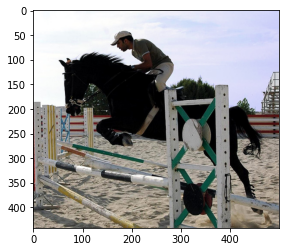

/home/innerwave/ailab/YYC/Pytorch 프로젝트/2. 물체감지/utils/data_augumentation.py:246: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  mode = random.choice(self.sample_options)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


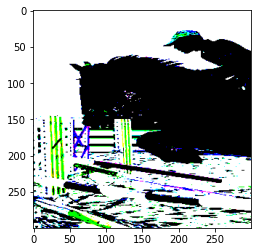

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


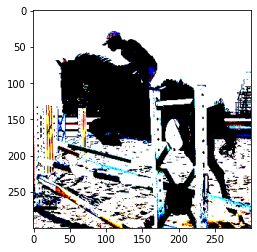

In [10]:
# 동작 확인

# 1. 화상읽기
image_file_path = train_img_list[0]
img = cv2.imread(image_file_path)  # [높이][폭][색BGR]
height, width, channels = img.shape  # 화상 크기 취득

# 2. 어노테이션을 리스트로
transform_anno = Anno_xml2list(voc_classes)
anno_list = transform_anno(train_anno_list[0], width, height)

# 3. 원본 표시
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

# 4. 전처리 클래스 작성
color_mean = (104, 117, 123)  # (BGR)색상의 평균값
input_size = 300  # 화상의 input 사이즈를 300×300으로 설정
transform = DataTransform(input_size, color_mean)

# 5. train 화상표시
phase = "train"
img_transformed, boxes, labels = transform(
    img, phase, anno_list[:, :4], anno_list[:, 4])
plt.imshow(cv2.cvtColor(img_transformed, cv2.COLOR_BGR2RGB))
plt.show()


# 6. val 화상 표시
phase = "val"
img_transformed, boxes, labels = transform(
    img, phase, anno_list[:, :4], anno_list[:, 4])
plt.imshow(cv2.cvtColor(img_transformed, cv2.COLOR_BGR2RGB))
plt.show()

In [11]:
# VOC2012의 데이터셋 작성


class VOCDataset(data.Dataset):
    """
    VOC2012의 Dataset을 만드는 클래스. 파이토치의 Dataset 클래스를 상속한다.

    Attributes
    ----------
    img_list : 리스트
        화상 경로를 저장한 리스트
    anno_list : 리스트
        어노테이션 경로를 저장한 리스트ㅜ
    phase : 'train' or 'test'
        학습 또는 훈련 설정
    transform : object
        전처리 클래스의 인스턴스
    transform_anno : object
        xml 어노테이션을 리스트로 변환하는 인스턴스
    """

    def __init__(self, img_list, anno_list, phase, transform, transform_anno):
        self.img_list = img_list
        self.anno_list = anno_list
        self.phase = phase  # train or test 지정 
        self.transform = transform  # 화상변형
        self.transform_anno = transform_anno  # 어노테이션 데이터를 xml에서 리스트로 변경

    def __len__(self):
        '''화상의 매수 반환'''
        return len(self.img_list)

    def __getitem__(self, index):
        '''
        전처리한 화상의 텐서 형식 데이터와 어노테이션 취득
        '''
        im, gt, h, w = self.pull_item(index)
        return im, gt

    def pull_item(self, index):
        '''전처리한 화상의 텐서 형식 데이터, 어노테이션, 화상의 높이, 폭 취득'''

        # 1. 화상읽기
        image_file_path = self.img_list[index]
        img = cv2.imread(image_file_path)  # [높이][폭][色BGR]
        height, width, channels = img.shape  # 화상 크기 취즉

        # 2. xml 형식의 어노테이션 정보를 리스트에 저장
        anno_file_path = self.anno_list[index]
        anno_list = self.transform_anno(anno_file_path, width, height)

        # 3. 전처리 실시
        img, boxes, labels = self.transform(
            img, self.phase, anno_list[:, :4], anno_list[:, 4])

        # 색상 채널의 순서가 BGR이므로 RGB로 순서 변경
        # (높이, 폭 색상 체널)의 순서를 (색상채널, 높이, 폭) 으로 변경
        img = torch.from_numpy(img[:, :, (2, 1, 0)]).permute(2, 0, 1)

        # BBox와 라벨을 세트로 한 np.array를 작성. 변수 이름 gt는 ground truth의 약칭
        gt = np.hstack((boxes, np.expand_dims(labels, axis=1)))

        return img, gt, height, width

In [12]:
# 동작 확인
color_mean = (104, 117, 123)  # (BGR)의 색의 평균값
input_size = 300  # 화상의 input 사이즈를 300x300 으로 변경

train_dataset = VOCDataset(train_img_list, train_anno_list, phase="train", transform=DataTransform(
    input_size, color_mean), transform_anno=Anno_xml2list(voc_classes))

val_dataset = VOCDataset(val_img_list, val_anno_list, phase="val", transform=DataTransform(
    input_size, color_mean), transform_anno=Anno_xml2list(voc_classes))


# 데이터 출력 예
val_dataset.__getitem__(1)

(tensor([[[   0.9417,    6.1650,   11.1283,  ...,  -22.9083,  -13.2200,
             -9.4033],
          [   6.4367,    9.6600,   13.8283,  ...,  -21.4433,  -18.6500,
            -18.2033],
          [  10.8833,   13.5500,   16.7000,  ...,  -20.9917,  -24.5250,
            -25.1917],
          ...,
          [ -23.9500,  -14.9000,   -1.7583,  ..., -108.6083, -111.0000,
           -117.8083],
          [ -28.2817,  -20.1750,   -5.5633,  ..., -104.9933, -111.8350,
           -119.0000],
          [ -20.4767,  -21.0000,  -12.6333,  ..., -107.1683, -115.7800,
           -117.1100]],
 
         [[  25.9417,   30.1650,   35.1283,  ...,  -18.0767,  -14.7250,
            -11.8533],
          [  31.4367,   33.6600,   37.8283,  ...,  -13.5017,  -10.8250,
            -10.3783],
          [  35.7917,   37.5500,   40.7000,  ...,  -11.8417,  -13.0750,
            -14.0167],
          ...,
          [  -1.9500,    7.1000,   20.2417,  ..., -101.9083, -102.0000,
           -109.7167],
          [  -6.2

In [13]:
def od_collate_fn(batch):
    """
    Dataset에서 꺼내는 어노테이션 데이터의 크기는 화상마다 다르다.
    화상 내의 물체 수가 두 개이면 (2,5) 사이즈지만 세 개이면 (3,5)등으로 바뀐다.
    변화에 대응하느 DataLoader를 만드는 collate_fn 작성
    collate_fn은 파이토치 리스트로 mini-batch를 작성하는 함수이다.
    미니 배치 분량의 화싱이 나열된 리스트 변수 batch에 미니 배치 번호를 지정하는 
    차원을 가장 앞에 하나 추가하여 리스트 형태를 변형한다.
    """

    targets = []
    imgs = []
    for sample in batch:
        imgs.append(sample[0])  # sample[0]은 화상 img
        targets.append(torch.FloatTensor(sample[1]))  # sample[1]은 어노테이션 gt

    # imgs는 미니 배치 크기의 리스트
    # 리스트 요소는 torch.Size([3, 300, 300])
    # 이 리스트를 torch.Size([batch_num, 3, 300, 300])의 텐서로 변환
    imgs = torch.stack(imgs, dim=0)

    # targets은 어노테이션의 정답인 gt의 리스트
    # 리스트 크기 = 미니 배치 크기
    # targets 리스트의 요소는 [n,5]
    # n은 화상마다 다르며 화상 속 물체의 수
    # 5는 [xmin, ymin, xmax, ymax, class_index] 

    return imgs, targets

In [14]:
# 데이터 로더 작성

batch_size = 4

train_dataloader = data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, collate_fn=od_collate_fn)

val_dataloader = data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, collate_fn=od_collate_fn)

# 사전형 변수에 정리
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

# 동작 확인
batch_iterator = iter(dataloaders_dict["val"])  # 반복자로 변환
images, targets = next(batch_iterator)  # 첫번째 요소 추출
print(images.size())  # torch.Size([4, 3, 300, 300])
print(len(targets[1]))
print(targets[1].size())  # 미니 배치 크기의 리스트, 각 요소는 [n,5], n은 물체 수

torch.Size([4, 3, 300, 300])
2
torch.Size([2, 5])


In [15]:
print(train_dataset.__len__())
print(val_dataset.__len__())

5717
5823
